In [1]:
from PaddleOCR import PaddleOCR,draw_ocr
import os
import shutil
import cv2
import matplotlib.pyplot as plt
import numpy as np
from yolov8.ultralytics import YOLO
import PIL
from PIL import Image
import math
import torch
from yolov8.ultralytics.nn.autobackend import AutoBackend
from yolov8.ultralytics.utils import ASSETS
# from yolov8.ultralytics.models.yolo.detect import DetectionPredictor
from yolov8.ultralytics.data.augment import LetterBox
from yolov8.ultralytics.utils.checks import check_imgsz, check_imshow
from yolov8.ultralytics.engine.results import Results
from yolov8.ultralytics.utils import ops

In [8]:
class Plate_Recognition():
    
    def __init__(self, yolo_weights="yolo_weights.pt", imgsz=640, device='cpu'): # det_th, nms_th, class_name, ocr_det, ocr_recog, lang='en'
        # __init__ yolov8 detection
        self.imgsz = imgsz
        if device == 'cpu':
            self.device = torch.device('cpu')
        else:
            self.device = torch.device('cuda')
        self.yolo_weights = yolo_weights
        self.yolo_model = AutoBackend(weights=self.yolo_weights,
                                      device=self.device,)
        self.yolo_model.eval()
        self.ocr_model = PaddleOCR(use_angle_cls=True, lang='en')
        self.font = 'PaddleOCR/simfang.ttf'
        # print(self.yolo_model)
    
    def Video_Inference(self, video, save_path):
        # Open the video file
        cap = cv2.VideoCapture(video)

        # Get video properties
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        # Define the codec and create VideoWriter object
        output_video_path = save_path
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

        # Process each frame
        while True:
            ret, frame = cap.read()

            if not ret:
                break  # Break the loop if the video is over

            # Draw a rectangle on the frame
            # Rectangle parameters: (image, start_point, end_point, color, thickness)
            result, rect = self.Image_Inference(frame)
            # Write the frame to the output video
            out.write(rect)

            # Break the loop if 'q' key is pressed
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break

        # Release the video capture and writer objects
        cap.release()
        out.release()

        # Close all OpenCV windows
    def Image_Inference(self, img, save_img=False):
    # video > result
        """
        Args: img (BGR) numpy
        Returns: plate_str (list of N str value): value of license plate
        ... --> save box and image output (if needed)
        """
        
        # im = img.copy()
        # Preprocess
        im = self._preprocess(img)
        detect_output = self.detect(im)
        # Detect plate boxes
        result, boxes_det, score = self._postprocess(detect_output, im, [img])
        box = boxes_det.numpy()
        txts = []
        imx = img
        # Read plate by OCR
        for i in range(box.shape[0]):
            tmp_box = box[i, :4]
            print(tmp_box)
            print(type(tmp_box))
            x1 = int(tmp_box[0])
            y1 = int(tmp_box[1])
            x2 = int(tmp_box[2])
            y2 = int(tmp_box[3])
            
            cropped_image = img[y1:y2, x1:x2]
            result_ocr = self.ocr_model.ocr(cropped_image)
            
            if result_ocr[0] is None:
                break
            print(result_ocr)
            boxes = [None] * len(result_ocr[0])
            txts = [None] * len(result_ocr[0])
            scores = [None] * len(result_ocr[0])
            imx = cv2.rectangle(img, (x1, y1), (x2, y2), color = (0, 255, 0))
            
            
            for idx, line in enumerate(result_ocr[0]):

                boxes[idx] = line[0]
                txts[idx] = line[1][0]
                scores[idx] = line[1][1]
                
            # Write output and save
            if save_img:

                out_im = self.visualize(cropped_image, boxes_det, txts, scores, self.font, end_path, image)
                pass
            
        return txts, imx
    def detect(self, im):
        
        """
        Use YOLOv8 model to detect plate:
        args:
        im (BCHW tensor image)
        
        return:
        boxes (list): object, format: [x, y, w, h]
        """
        
        return self.yolo_model(im)

    def __call__(self, img, save_path):
        image = cv2.imread(img) # BGR image
        img_resize = self._preprocess(image) #, input_size
        ocr = PaddleOCR(use_angle_cls=True, lang='en')
        # Load a pretrained YOLOv8n model
        det_model = YOLO('yolo_weights.pt')
        

        # Perform inference on an image
        result_0 = self.detect(img_resize)
        # Extract bounding boxes, classes, names, and confidences
        
        box_det, boxes_det, score = self._postprocess(result_0, img_resize, [image])

        # REplace img by image line  image = cv2.imread(img) # BGR image
        # Check carefully: BGR / RGB / shape

        # Crop image
        box = boxes_det.numpy() # boxes_det has N boxes pred[:, :4] --> pred.shape[0] = N
        # for i in range N: --> tmp_box = pred[i,:4] ....
        x1 = int(box[0][0])
        y1 = int(box[0][1])
        x2 = int(box[0][2])
        y2 = int(box[0][3])
        cropped_image = image[y1:y2, x1:x2]
        # final_path = save_path + '/cropped_image.jpg'
        
        result_1 = self.ocr_model.ocr(cropped_image)

        # run save_ocr
        end_path = os.path.join(save_path + '/', 'output.jpg')
        print(end_path)

        
        boxes = [None] * len(result_1[0])
        txts = [None] * len(result_1[0])
        scores = [None] * len(result_1[0])
        for idx, line in enumerate(result_1[0]):

            boxes[idx] = line[0]
            txts[idx] = line[1][0]
            scores[idx] = line[1][1]

        self.visualize(cropped_image, boxes_det, txts, scores, self.font, end_path, image)
        # detect plate obj (copy paste)

        return box, txts, cropped_image, end_path # score

    def _preprocess(self, im): #, input_size

        """
        Args: Input : im <numpy array>: HWC
                imgsz: output image size (return im <imgsz imgsz>)
        Return:
                img (float 0-1): BCHW
        """

        letterbox = LetterBox(new_shape=(self.imgsz, self.imgsz))
        img = letterbox(image=im)
        img = img[..., ::-1].transpose((2, 0, 1)) # BGR -> RGB; HWC -> CHW (this is for 1 image)
        img = np.ascontiguousarray(img) # convert, ensure img = np.array format
        img = torch.from_numpy(img).to(self.device).float() # convert to torch + send to device + convert from uint8 > float
        img /= 255 # normalize
        if len(img.shape) == 3:
            img = img[None]  # expand for batch dim (CHW -> BCHW)

        return img

    def _postprocess(self, preds, img, orig_imgs):
        """
        Post-processes predictions and returns a list of Results objects.
        Args:
                preds: i forgor
                img: resized image from preprocessing
                orig_imgs: input image
        
        Returns:
                results: i forgor
                pred[:, :4]: bounding boxes
                score: confidence score
        """
        
        preds = ops.non_max_suppression(preds,
                                        conf_thres=0.25,
                                        iou_thres=0.45,
                                        max_det=100)

        # print(preds, len(preds))
        # if not isinstance(orig_imgs, list):  # input images are a torch.Tensor, not a list
            # orig_imgs = ops.convert_torch2numpy_batch(orig_imgs)
        # print(len(orig_imgs))

        results = []
        for i, pred in enumerate(preds):
            orig_img = orig_imgs[i]
            # print(pred[:, :4])
            score = pred[:, 4]
            print(score)
            pred[:, :4] = ops.scale_boxes(img.shape[2:], pred[:, :4], orig_img.shape)
            results.append(Results(orig_img, path=None, names=self.yolo_model.names, boxes=pred))
        # print(img.shape[2:], pred[:, :4], orig_img.shape)
        return results, pred[:, :4], score
    
    def visualize(self, cropped_img, boxes, txts, scores, font, save_path, original):
        boxes = boxes.numpy()
        x1 = int(boxes[0][0])
        y1 = int(boxes[0][1])
        x2 = int(boxes[0][2])
        y2 = int(boxes[0][3])

        imx = cv2.rectangle(original, (x1, y1), (x2, y2), color = (0, 255, 0))
        plt.imshow(imx)
        
        # cv2cropped = cv2.imread(cropped_img)
        im_show = draw_ocr(cropped_img, boxes, txts, scores, font_path=font)
        print(boxes)
        print(txts)
        print(scores)
        cv2.imwrite(save_path, im_show)

        img = cv2.cvtColor(im_show, cv2.COLOR_BGR2RGB)
        plt.imshow(img)

In [9]:
det_model = YOLO('yolo_weights.pt')
detector = Plate_Recognition()

Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


[2024/01/23 15:59:10] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\PC/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\PC/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25

In [10]:
detector.Video_Inference('test_dataset/inference_test_trim.mp4', 'save_path/output_video.mp4')

tensor([0.7811])
[     567.73      472.87      642.69      529.26]
<class 'numpy.ndarray'>
[2024/01/23 15:59:11] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.042417287826538086
[2024/01/23 15:59:11] ppocr DEBUG: cls num  : 2, elapsed : 0.03443121910095215
[2024/01/23 15:59:11] ppocr DEBUG: rec_res num  : 2, elapsed : 0.26952624320983887
[[[[[13.0, 7.0], [64.0, 7.0], [64.0, 31.0], [13.0, 31.0]], ('51G', 0.7305739521980286)], [[[5.0, 28.0], [71.0, 28.0], [71.0, 52.0], [5.0, 52.0]], ('981.29', 0.9759418368339539)]]]
tensor([0.7723])
[     559.39      476.98      635.57      533.22]
<class 'numpy.ndarray'>
[2024/01/23 15:59:12] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.012811660766601562
[2024/01/23 15:59:12] ppocr DEBUG: cls num  : 2, elapsed : 0.02338695526123047
[2024/01/23 15:59:12] ppocr DEBUG: rec_res num  : 2, elapsed : 0.230025053024292
[[[[[14.0, 7.0], [64.0, 7.0], [64.0, 31.0], [14.0, 31.0]], ('51G', 0.761174201965332)], [[[5.0, 25.0], [73.0, 27.0], [71.0, 54.0], [3.0, 51.0]], ('9

In [19]:
im = cv2.imread('test_dataset/img1.jpg')
detector.Image_Inference(im)

tensor([0.7527])
[[     88.192      118.75      193.87      145.53]]
[     88.192      118.75      193.87      145.53]
[2024/01/20 15:49:30] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.015622138977050781
[2024/01/20 15:49:30] ppocr DEBUG: cls num  : 1, elapsed : 0.01806473731994629
[2024/01/20 15:49:30] ppocr DEBUG: rec_res num  : 1, elapsed : 0.13093805313110352
['60A-999.99']


NameError: name 'plate_str' is not defined

[2024/01/20 15:43:15] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\PC/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\PC/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25

(array([[     88.192,      118.75,      193.87,      145.53]], dtype=float32),
 ['60A-999.99'],
 array([[[  0, 255,   0],
         [  0, 255,   0],
         [  0, 255,   0],
         ...,
         [  0, 255,   0],
         [  0, 255,   0],
         [  0, 255,   0]],
 
        [[  0, 255,   0],
         [ 21,  14,   5],
         [ 16,   9,  14],
         ...,
         [ 24,  13,   5],
         [ 22,  13,   4],
         [ 29,  20,  10]],
 
        [[  0, 255,   0],
         [ 97,  93,  92],
         [106, 101, 122],
         ...,
         [179, 169, 162],
         [120, 111, 102],
         [ 67,  58,  48]],
 
        ...,
 
        [[  0, 255,   0],
         [ 50,  39,  31],
         [ 22,  18,  37],
         ...,
         [ 19,  14,  11],
         [ 20,  15,  14],
         [ 81,  76,  75]],
 
        [[  0, 255,   0],
         [ 46,  33,  17],
         [ 36,  28,  29],
         ...,
         [ 33,  24,  20],
         [ 52,  46,  41],
         [ 10,   2,   2]],
 
        [[  0, 255,   0]

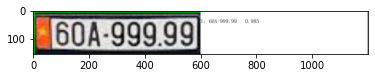

In [80]:
detector.__call__('test_dataset/img1.jpg', 'save_path')

In [3]:
im = cv2.imread('test_dataset/117.jpg')
cropped_image = im[455:543, 519:638]
cv2.imshow('Original Image', im)
cv2.imshow('Cropped Image', cropped_image)
cv2.waitKey(10000)
cv2.destroyAllWindows()

In [6]:
ocr = PaddleOCR(use_angle_cls=True, lang='en')
ocr.ocr(im)

[2024/01/17 20:51:41] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\PC/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\PC/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25

[[[[[219.0, 457.0], [315.0, 434.0], [324.0, 473.0], [228.0, 496.0]],
   ('29-V7', 0.8630657196044922)],
  [[[536.0, 462.0], [627.0, 465.0], [626.0, 505.0], [534.0, 501.0]],
   ('89-L1', 0.9760593175888062)],
  [[[1062.0, 458.0], [1158.0, 444.0], [1164.0, 484.0], [1068.0, 498.0]],
   ('18-B2', 0.9009889364242554)],
  [[[224.0, 494.0], [336.0, 469.0], [346.0, 514.0], [233.0, 539.0]],
   ('376.94', 0.9965934753417969)],
  [[[525.0, 505.0], [633.0, 505.0], [633.0, 543.0], [525.0, 543.0]],
   ('384.24', 0.9888271689414978)],
  [[[1059.0, 498.0], [1177.0, 480.0], [1183.0, 523.0], [1066.0, 542.0]],
   ('547.79', 0.9951658844947815)]]]

a
